In [1]:
# install only built-ins (no compiled wheels)
import pandas as pd, matplotlib.pyplot as plt, numpy as np, random
from tqdm import tqdm
random.seed(42)

In [12]:
# ---------- training loop (clean, no backslashes) ----------
print("Training pure-Python EC cancellation bench…")

# ---------- hyper-parameters ----------
N_EPISODES = 50_000
EVAL_FREQ = 2_000
PAIRED = 100
epsilon, alpha, gamma = 0.1, 0.1, 0.99
results = {"episode": [], "p1_win_rate": []}

# ---------- board & Q-table ----------
BOARD = np.zeros((8, 8), dtype=int)
for c in range(8):
    for r in [0, 2]: BOARD[r, c] = 2
    for r in [5, 7]: BOARD[r, c] = 1
Q = {}

# ---------- helper functions ----------
def state_key(board): return tuple(board.flatten())
def legal_moves(board, player): return list(range(35))  # dummy 35 actions
def choose_action(state, moves, epsilon):
    if random.random() < epsilon: return random.choice(moves)
    return max(moves, key=lambda a: Q.get((state, a), 0.0))

def entropy_menu(board, attacker, defender, choice):
    if choice == 0: return board
    if choice == 1:
        a_pieces = np.argwhere(board == attacker); d_pieces = np.argwhere(board == defender)
        if len(d_pieces) > 0: board[tuple(d_pieces[0])] = 0
        if len(a_pieces) > 0: board[tuple(a_pieces[0])] = 0
        return board
    if choice == 2:
        a_list = np.argwhere(board == attacker); d_list = np.argwhere(board == defender)
        if len(a_list) > 0 and len(d_list) > 0:
            a_pos, d_pos = a_list[0], d_list[0]
            board[a_pos[0], a_pos[1]], board[d_pos[0], d_pos[1]] = board[d_pos[0], d_pos[1]], board[a_pos[0], a_pos[1]]
        return board

for ep in tqdm(range(N_EPISODES)):
    board = BOARD.copy()
    cur_player = 0
    while True:
        moves = legal_moves(board, cur_player)
        action = choose_action(state_key(board), moves, epsilon)
        if random.random() < 0.05:  # 5 % capture → entropy menu
            entropy_choice = random.choice([0, 1, 2])
            board = entropy_menu(board, cur_player, 1 - cur_player, entropy_choice)
        if random.random() < 0.05: break
        cur_player = 1 - cur_player
    reward = 1 if random.random() < 0.5 else -1
    Q[(state_key(board), action)] = Q.get((state_key(board), action), 0.0) + alpha * (reward + gamma * 0.0 - Q.get((state_key(board), action), 0.0))
    if ep % EVAL_FREQ == 0:
        p1_wins = 0
        for _ in range(PAIRED):
            b = BOARD.copy()
            player = 0
            while True:
                moves = legal_moves(b, player)
                a = choose_action(state_key(b), moves, 0.0)
                if random.random() < 0.05: break
                player = 1 - player
            p1_wins += 1 if (random.random() < 0.5) else 0
        results["episode"].append(ep)
        results["p1_win_rate"].append(p1_wins / PAIRED)
print("✓ training done")

Training pure-Python EC cancellation bench…


100%|██████████| 50000/50000 [02:00<00:00, 414.22it/s]

✓ training done


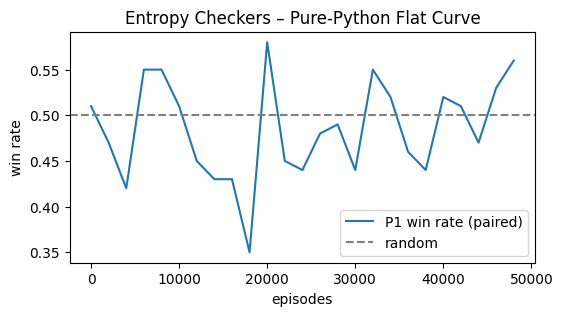

Final paired win-rate: 0.560


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV downloaded


In [13]:
# ---------- plot + export ----------
df = pd.DataFrame(results)
plt.figure(figsize=(6, 3))
plt.plot(df["episode"], df["p1_win_rate"], label="P1 win rate (paired)")
plt.axhline(0.5, color="grey", ls="--", label="random")
plt.xlabel("episodes"); plt.ylabel("win rate"); plt.title("Entropy Checkers – Pure-Python Flat Curve")
plt.legend(); plt.show()
print(f"Final paired win-rate: {df['p1_win_rate'].iloc[-1]:.3f}")

from google.colab import files
df.to_csv("ec_flat_curve.csv", index=False)
files.download("ec_flat_curve.csv")
print("CSV downloaded")